In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        S = S.unsqueeze(0) #(1, T_data, in_no)
        lstm_out, hs = self.lstm(S) #(1, T_data, H_no)
        out = self.linear(lstm_out.squeeze(0)).flatten()
        
        return out, lstm_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 50
layer_no = 1
in_no = e_idx.shape[0] + i_idx.shape[0]
#in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

53901


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, _ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])))
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, _ = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])))
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        print(i, test_score, test_mse, train_score, loss.item())


<ipython-input-7-164be5a8b32d>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.0025326013565063477 0.030593091621994972 2.2649765014648438e-05 0.045517098158597946
49 0.06851345300674438 0.025342606008052826 0.07079535722732544 0.0248867180198431
99 0.25648242235183716 0.020329255610704422 0.22287338972091675 0.01937323994934559
149 0.27040213346481323 0.020184097811579704 0.26794809103012085 0.019855231046676636
199 0.2774103283882141 0.01965523324906826 0.21389973163604736 0.025110654532909393
249 0.2819913625717163 0.019802555441856384 0.27642762660980225 0.023150712251663208
299 0.290105938911438 0.019307270646095276 0.24186450242996216 0.026513641700148582
349 0.30357658863067627 0.01906135492026806 0.2494012713432312 0.026510778814554214
399 0.29875534772872925 0.01907310076057911 0.280414879322052 0.025701414793729782
449 0.26496219635009766 0.01999034360051155 0.3098648190498352 0.014686455018818378
499 0.3065115213394165 0.018863508477807045 0.32442349195480347 0.018198681995272636
549 0.2823643088340759 0.019601736217737198 0.2864970564842224 0.0188

KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_l1_h50_model.pt")
np.save("/media/hdd01/sklee/CA1_clust4-60/gru_l1_h50_test.npy", test_V_pred.cpu().detach().numpy())

In [12]:
model = GenericGRU(T_no, H_no, layer_no, in_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_l1_h10_model.pt"))
model.eval()

GenericGRU(
  (lstm): GRU(307, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
lin_out, rnn_out = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])).cpu())

In [14]:
H = rnn_out.squeeze(0).cpu().detach().numpy()

[3 9 3 2 5 1 6 2 9 2]


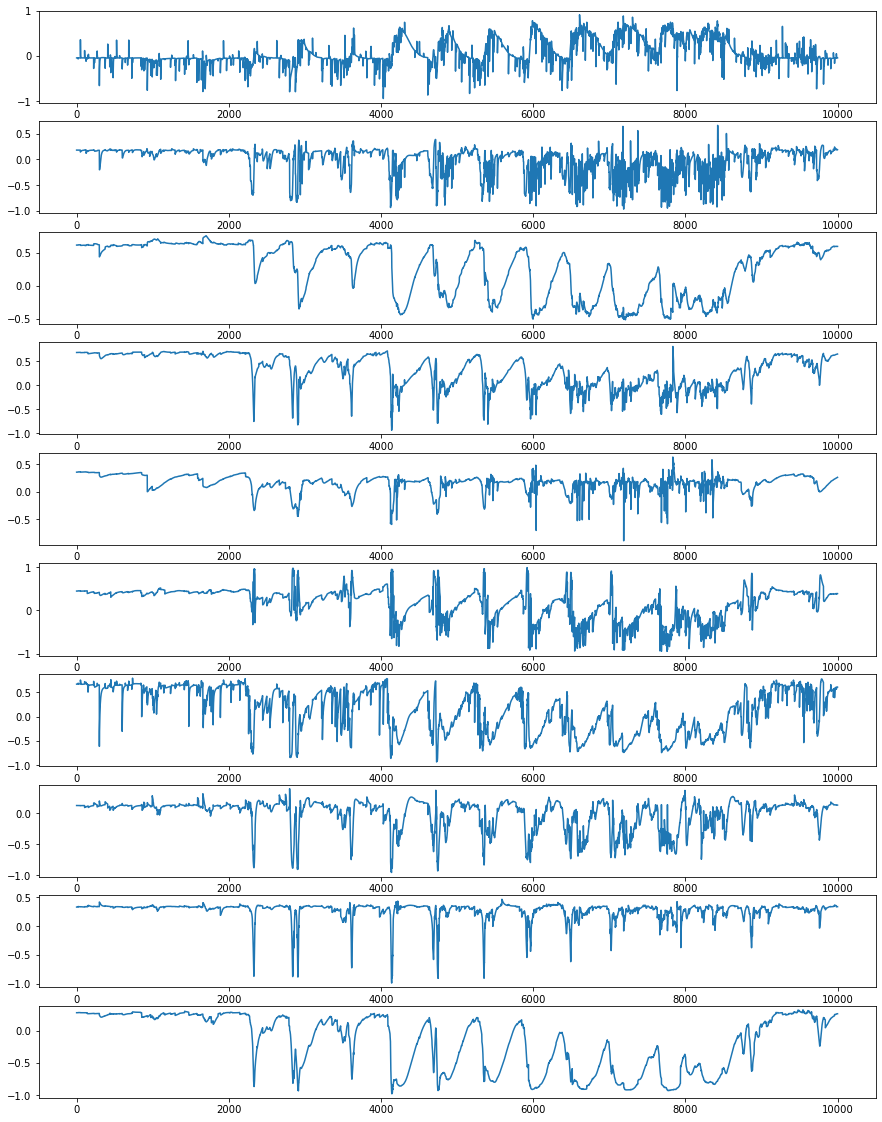

In [18]:
#idx = np.random.randint(0,10, 10)
print(idx)
fig, axs = plt.subplots(nrows=10, figsize=(15,20))
for i in range(10):
    axs[i].plot(H[:,i][16000:26000])

In [19]:
W = model.lstm.weight_ih_l0[:,].cpu().detach().numpy()
print(W.shape)

(30, 307)


0.72929996


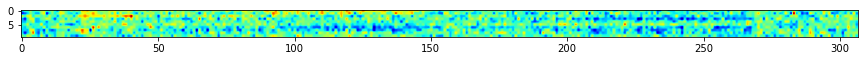

In [23]:
plt.figure(figsize = (15,5))
plt.imshow(W[:10], cmap="jet")
#plt.colorbar()
print(np.var(W[:10]))

0.3550791


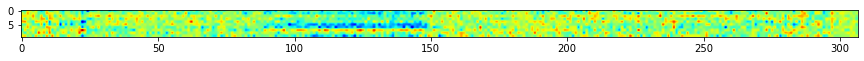

In [24]:
plt.figure(figsize = (15,5))
plt.imshow(W[20:30], cmap="jet")
#plt.colorbar()
print(np.var(W[20:30]))

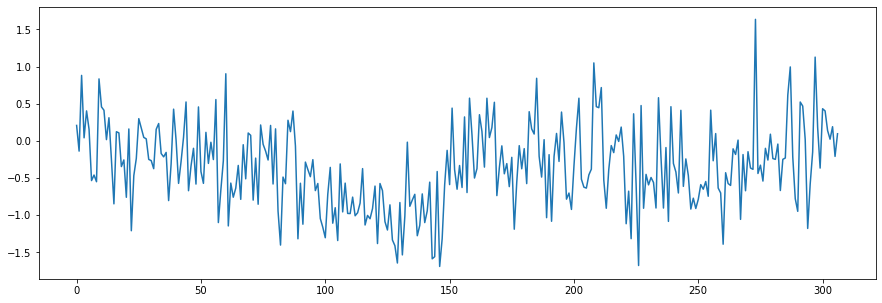

In [26]:
plt.figure(figsize = (15,5))
plt.plot(W[20:30][1])

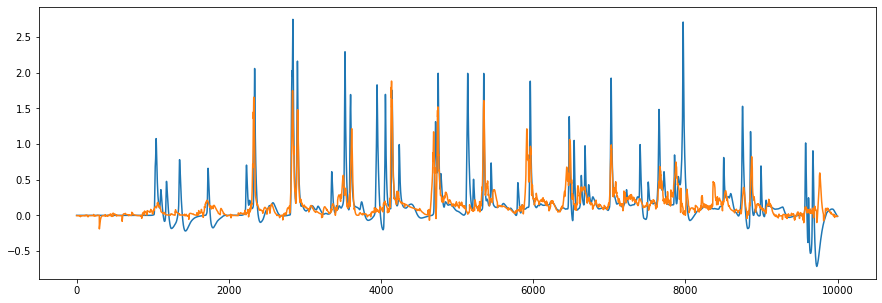

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

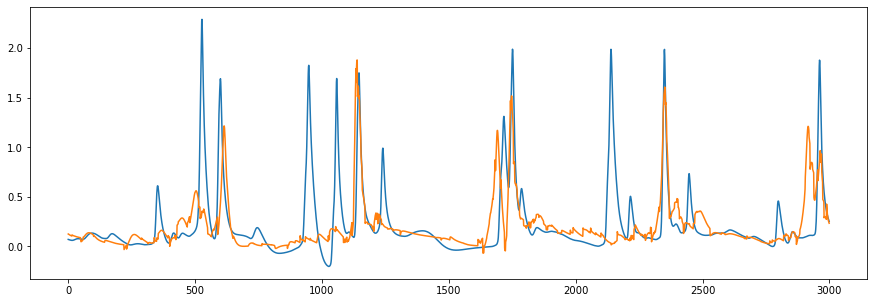

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

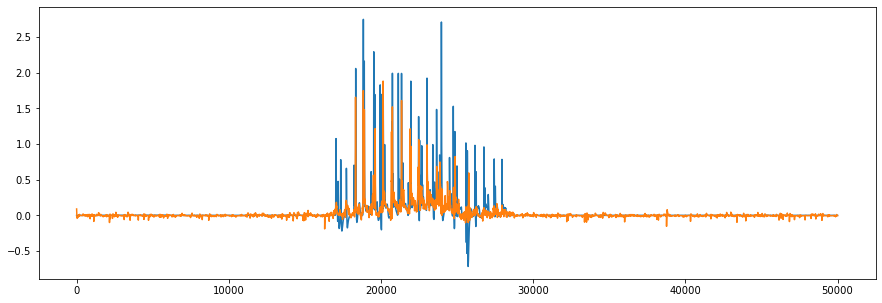

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())